## Brazillian E-Commerce Dataset
#### Downloaded from [Kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce)

**About the data:**
> The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

**About Olist.com**
> This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners.

**Attention**
- An order might have multiple items.
- Each item might be fulfilled by a distinct seller.
- All text identifying stores and partners where replaced by the names of Game of Thrones great houses.

**Schema**
<img src="ds-schema.png" style="width: 600px;">

### Description of columns

| Dataset | Column  | Description  |
| --- | --- | --- |
| *Orders* | order_id | unique identifier of the order. |
| *Orders* | customer_id | key to the customer dataset. Each order has a unique customer_id. |
| *Orders* | order_status | Reference to the order status (delivered, shipped, etc). |
| *Orders* | order_purchase_timestamp | Shows the purchase timestamp. |
| *Orders* | order_approved_at | Shows the payment approval timestamp. |
| *Orders* | order_delivered_carrier_date | Shows the order posting timestamp. When it was handled to the logistic partner. |
| *Orders* | order_delivered_customer_date | Shows the actual order delivery date to the customer. |
| *Orders* | order_estimated_delivery_date | Shows the estimated delivery date that was informed to customer at the purchase moment. |
| --- | --- | --- |
| *Payments* | payment_sequential | a customer may pay with more than one payment method. If so, a sequence will be created to accommodate all payments. |
| *Payments* | payment_type | method of payment chosen by the customer. |
| *Payments* | payment_installments | number of installments chosen by the customer. |
| *Payments* | payment_value | transaction value. |
| --- | --- | --- |
| *Reviews* | review_id | unique review identifier |
| *Reviews* | review_score | Note ranging from 1 to 5 given by the customer on a satisfaction survey. |
| *Reviews* | review_comment_title | Comment title from the review left by the customer, in Portuguese. |
| *Reviews* | review_comment_message | Comment message from the review left by the customer, in Portuguese. |
| *Reviews* | review_creation_date | Shows the date in which the satisfaction survey was sent to the customer. |
| *Reviews* | review_answer_timestamp | Shows satisfaction survey answer timestamp. |
| --- | --- | --- |
| *Items* | order_item_id | sequential number identifying number of items included in the same order. |
| *Items* | product_id | product unique identifier |
| *Items* | seller_id | seller unique identifier |
| *Items* | shipping_limit_date | Shows the seller shipping limit date for handling the order over to the logistic partner. |
| *Items* | price | item price |
| *Items* | freight_value | item freight value item (if an order has more than one item the freight value is splitted between items) |
| --- | --- | --- |
| *Products* | product_category_name | root category of product, in Portuguese. |
| *Products* | product_name_lenght | number of characters extracted from the product name. |
| *Products* | product_description_lenght | number of characters extracted from the product description. |
| *Products* | product_photos_qty | number of product published photos |
| *Products* | product_weight_g | product weight measured in grams. |
| *Products* | product_length_cm | product length measured in centimeters. |
| *Products* | product_height_cm | product height measured in centimeters. |
| *Products* | product_width_cm | product width measured in centimeters. |

In [863]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm

In [864]:
# matplotlib params
hfont = {'fontname':'sans-serif'}

# pandas params
pd.options.display.max_rows = 100

In [865]:
data_path = 'C:/Users/Zaca/Documents/Datasets/brazilian-ecommerce/olist_'

In [866]:
# opening datasets individually (ignored customers and sellers)
orders = pd.read_csv(data_path + 'orders_dataset.csv')
items = pd.read_csv(data_path + 'order_items_dataset.csv')
products = pd.read_csv(data_path + 'products_dataset.csv')
payments = pd.read_csv(data_path + 'order_payments_dataset.csv')
reviews = pd.read_csv(data_path + 'order_reviews_dataset.csv')

data = {'orders': orders,
        'items': items, 
        'products': products,
        'payments': payments,
        'reviews': reviews}

## Data cleaning

### Orders
- This is the most important data set as its like a *linking table*, and is connected to a lot of other datatsets by *order_id*.

In [867]:
print('Order cols: ' , data['orders'].columns.values)

# i've decided I'm not interested in order_approved, and order_delivered_carrier_date
orders_drop_cols = ['order_approved_at', 
                    'order_delivered_carrier_date']

data['orders'].drop(orders_drop_cols, axis= 1, inplace= True)

Order cols:  ['order_id' 'customer_id' 'order_status' 'order_purchase_timestamp'
 'order_approved_at' 'order_delivered_carrier_date'
 'order_delivered_customer_date' 'order_estimated_delivery_date']


In [868]:
# for the purpose of this analysis I'll be selecting only orders that have been in fact, delivered
print(data['orders']['order_status'].value_counts())

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64


In [869]:
print('Taking only delivered orders we still get ' + 
      str(round((data['orders'].order_status.value_counts()['delivered']/len(data['orders']))*100,2)) +
      '% of data.')

Taking only delivered orders we still get 97.02% of data.


In [870]:
# first I will get all order_id where the order status was delivered
delivered = data['orders']['order_id'][data['orders']['order_status'] != 'delivered'].values

# now filter every other dataframe where order_id is a foreign key
for key, value in data.items():
    if 'order_id' in value.columns:
        value.drop(value.loc[value['order_id'].isin(delivered)].index, inplace = True)


In [871]:
# checking for nans in each dataset
for key, value in data.items():
    for col in value.columns:
        # print only col names where there are nans
        if value[col].isnull().sum():
            print(col + ' (%): ' + str((sum(value[col].isnull())/len(ds))*100))

order_delivered_customer_date (%): 0.006761610953809745
product_category_name (%): 0.5155728352279931
product_name_lenght (%): 0.5155728352279931
product_description_lenght (%): 0.5155728352279931
product_photos_qty (%): 0.5155728352279931
product_weight_g (%): 0.0016904027384524363
product_length_cm (%): 0.0016904027384524363
product_height_cm (%): 0.0016904027384524363
product_width_cm (%): 0.0016904027384524363
review_comment_title (%): 72.42530532899464
review_comment_message (%): 48.3979208046317


In [872]:
# let's deal first with orders nans
# I've observed that these nans in the orders list are not really overlapping, and the only ones I really
# care about are the delivered_customer_date.
print('There are only ' + str(data['orders'].order_delivered_customer_date.isnull().sum()) + 
      ' orders that are missing delivery dates.')

There are only 8 orders that are missing delivery dates.


In [873]:
# we can drop them the same way as before
# first I will get all order_id where the order status was delivered
null_deliveries = data['orders']['order_id'][data['orders']['order_delivered_customer_date'].isnull()].values

# now filter every other dataframe where order_id is a foreign key
for key, value in data.items():
    if 'order_id' in value.columns:
        value.drop(value.loc[value['order_id'].isin(null_deliveries)].index, inplace = True)

In [874]:
# there are 3 date columns in the orders dataset that I will transform to datetime and keep only the date
# ignoring hours minutes and seconds
data['orders'].order_purchase_timestamp = pd.to_datetime(data['orders'].order_purchase_timestamp).dt.date
data['orders'].order_delivered_customer_date = pd.to_datetime(data['orders'].order_delivered_customer_date).dt.date
data['orders'].order_estimated_delivery_date = pd.to_datetime(data['orders'].order_estimated_delivery_date).dt.date

In [875]:
# I'm not particularly interested in the actual date of delivery, but more if it was delivered on time
data['orders']['delivered_on_time'] = np.where(data['orders'].order_delivered_customer_date < data['orders'].order_estimated_delivery_date, 1, 0)

**Note:** *this column could be used with a geometric distribution? For example: how many orders until one doesn't get delivered on time?* 

TODO: demonstrate it's a geometric distribution (Goodness of Fit on Monday)

### Reviews

In [876]:
print('Review cols: ' , data['reviews'].columns.values)

Review cols:  ['review_id' 'order_id' 'review_score' 'review_comment_title'
 'review_comment_message' 'review_creation_date' 'review_answer_timestamp']


In [877]:
# the review_comment_title column is 88% NaN so i'll just drop it. 
# TODO: nans for reviews just means there are none (?). 
# So maybe just assume that's all there is and use the data separately for a etxt analysis (in M3) ENDTODO

# and when the review was sent to the customer
review_drop_cols = ['review_comment_title']
data['reviews'].drop(review_drop_cols, axis= 1, inplace= True)

In [878]:
# for now I won't do any text analysis so I'm not super interested in the comment message
# it looks like in this column there are nans if people did not leave a review
# I don't want to drop the column, so I will just replace nan by 0 and the review by 1
data['reviews']['review_comment_message'] = np.where(data['reviews']['review_comment_message'].isnull(), 0, 1)

### Products

In [879]:
print('Product cols: ' , data['products'].columns.values)

# I've decided I'm not interested in the length of the name or the description of the product (too many nans)
# also I can't think of anything to do with the size attributes of each product
product_drop_cols = ['product_name_lenght', 
                     'product_description_lenght', 
                     'product_weight_g', 
                     'product_length_cm', 
                     'product_height_cm',
                     'product_width_cm']

data['products'].drop(product_drop_cols, axis= 1, inplace= True)

Product cols:  ['product_id' 'product_category_name' 'product_name_lenght'
 'product_description_lenght' 'product_photos_qty' 'product_weight_g'
 'product_length_cm' 'product_height_cm' 'product_width_cm']


In [880]:
# after looking at a gigantic list of categories for products 
# I think it's safe to assume that I can replace nans in these columns by 'other'
data['products']['product_category_name'].fillna(value='outro', inplace=True)

In [881]:
# there are no zeros in the photos_qty column, somehow I doubt there are NO products with zero photos
# will fill nans with zero in this column
data['products']['product_photos_qty'].fillna(value=0, inplace=True)

TODO: profile of the most sold product, and probability of selling that product. Do they earn more by selling more expensive products or less expensive? (based on the probability of selling them)

### Payments

In [882]:
# i'll keep all these for now.
print('Payment cols: ' , data['payments'].columns.values)

Payment cols:  ['order_id' 'payment_sequential' 'payment_type' 'payment_installments'
 'payment_value']


### Items

In [883]:
# i'll keep all these for now.
print('Item cols: ' , data['items'].columns.values)
data['items'].shipping_limit_date = pd.to_datetime(data['items'].shipping_limit_date).dt.date

Item cols:  ['order_id' 'order_item_id' 'product_id' 'seller_id' 'shipping_limit_date'
 'price' 'freight_value']


## Exploratory Data Analysis

### Orders
#### Delivered on time?

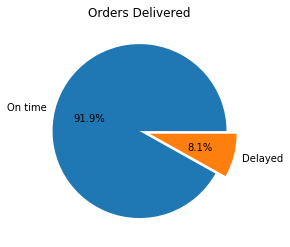

In [884]:
# let's see the proportion of deliveries that arrive before the estimated date.
fig, ax = plt.subplots()
plt.title('Orders Delivered',**hfont)
labels = 'On time', 'Delayed'
prob_on_time = data['orders'].delivered_on_time.sum()/len(data['orders'].delivered_on_time)
sizes = [prob_on_time, 1 - prob_on_time]
explode = (0, 0.12)
ax.pie(sizes, explode, labels, autopct='%1.1f%%');

#### Timeseries of orders

First registered order:  2016-09-15
Last registered order:  2018-08-29


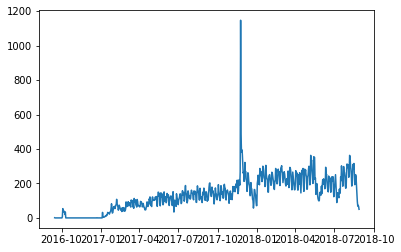

In [885]:
# purchase_timestamp also has interesting information about the frequency of orders
min_order_date = data['orders'].order_purchase_timestamp.min()
max_order_date = data['orders'].order_purchase_timestamp.max()
print('First registered order: ', min_order_date)
print('Last registered order: ', max_order_date)

# creating a list of days between the beggining of the dataset and the end.
order_dates = [min_order_date + datetime.timedelta(days= i) for i in range((max_order_date - min_order_date).days)]

# I want to histogram the dates and then plot a line
# but numpy histogram only works with numbers so we need to do the following
to_timestamp = np.vectorize(lambda x: (x - dt.date(1970, 1, 1)).total_seconds())
time_stamps = to_timestamp(data['orders'].order_purchase_timestamp)
order_histogram = np.histogram(time_stamps, bins = len(order_dates))[0]


fig, ax = plt.subplots()
ax.plot(order_dates, order_histogram);

In [886]:
# cool peak, let's check the date of when this happened
dates_and_counts = list(zip(order_dates, order_histogram))
print('Highest order date: ' + str(max(dates_and_counts, key=lambda x: x[1])[0]))
print('# of orders: ' + str(max(dates_and_counts, key=lambda x: x[1])[1]))

Highest order date: 2017-11-24
# of orders: 1147


#### Seasonal analysis

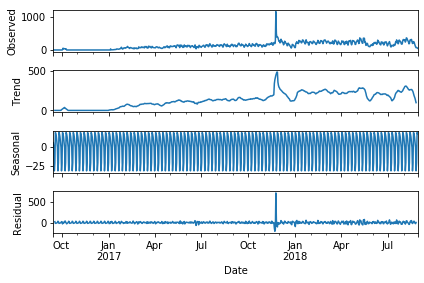

In [887]:
# place data into DataFrame
timeseries = pd.DataFrame(dates_and_counts, columns=['Date', 'Orders'])

# convert date column into datetime... again.
timeseries['Date'] = pd.to_datetime(timeseries['Date'])

# set Date as index and drop it.
timeseries.set_index('Date', drop=True, inplace=True)

# run decomposition model
decomposition = sm.tsa.seasonal_decompose(timeseries, model= 'additive')

# plot, my god it is horrible. TODO: make plot nicer.
fig = decomposition.plot()
plt.show()

#### Better seasonal analysis

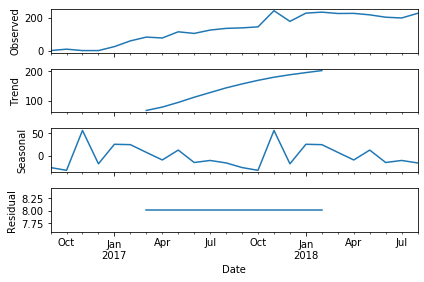

In [888]:
# ok let's try this again by with resampling, this might be too much data :D
decomposition = sm.tsa.seasonal_decompose(timeseries.resample('M').mean(), model='additive')
fig = decomposition.plot()

### here goes an attempt to interpret this.
*the statsmodels seasonal decomposition returns 4 objects that are plotted here.*
- **observed** - The data series that has been decomposed - *i think the rolling mean of the input data*
- **seasonal** - The seasonal component of the data series - *seasonality, high on black friday, small bump again on jan/feb*
- **trend** - The trend component of the data series - *it goes up, they have more and more customers over time*
- **resid** - The residual component of the data series - *oops this doesn't look good*

### Black Friday

- *it seems that 24/11/2017 was [Black Friday](https://en.wikipedia.org/wiki/Black_Friday_(shopping)). it could be interesting (TODO) to see the average price of items bought that day agains the price of the same items any other day. also, there are two years so why only one peak? (TODO: compare the two different Black Fridays, is the avg same?) maybe there were no discounts in the other black friday (Friday, November 25)*

- *Product sold on Black Friday VS general product. How common is normally to sell the products they sell during Black Friday?*

In [899]:
# based on the schema, we merge the products dataset with the items dataset
items_product = data['items'].merge(data['products'], on= 'product_id', how= 'inner')

# store the black friday dates
black_friday_2016 = dt.date(2016, 11, 25)
black_friday_2017 = dt.date(2017, 11, 24)

# filter order_id by black friday date
bf17_orders = data['orders'][data['orders']['order_purchase_timestamp'] == black_friday_2017]['order_id'].values

# use order_id to get products
bf17_products = items_product[items_product['order_id'].isin(bf17_orders)]
bf17_products['product_id'].value_counts()

422879e10f46682990de24d770e7f83d    25
368c6c730842d78016ad823897a372db    23
9ecadb84c81da840dbf3564378b586e9    18
53759a2ecddad2bb87a079a1f1519f73    18
389d119b48cf3043d311335e499d9c6b    14
                                    ..
12dc5e5d178b930cf87cf16e812fc2d5     1
d3257d83b50d04301c9d969a0e2ec4ee     1
62c89abe1afe3a23c17765d462718a4c     1
4eebe44f76b0976eab5c92eebeac8b55     1
9e0e152552a1323f7e5dcf63d50cdae3     1
Name: product_id, Length: 901, dtype: int64

### Payments

In [891]:
print(data['payments'].columns)

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')


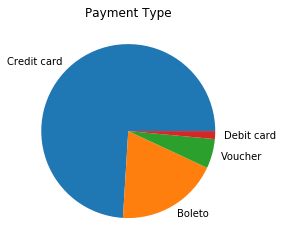

In [892]:
# let's see the proportion of payments by payment type
payment_types = data['payments'].payment_type.value_counts()

# show a pie plot
fig, ax = plt.subplots()
plt.title('Payment Type',**hfont)
labels = [x.replace('_', ' ').capitalize() for x in payment_types.index]
sizes = payment_types.values
ax.pie(x= sizes, labels=labels);

*one idea I have with the payments dataset is the relationship between the number of installments and the price of the order, maybe there's some form os probability distribution that we can model?*

### Reviews

(array([ 9753.,  3015.,  8056., 19040., 57143.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

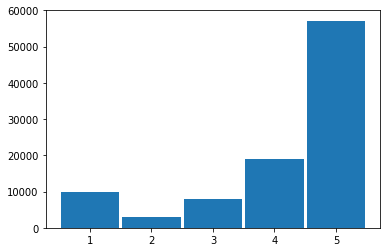

In [893]:
# first thing we might look at is the distribution of review scores
plt.xticks([x + 0.5 for x in range(1, 7)], range(1, 7))
plt.hist(data['reviews'].review_score, bins= range(1, 7), rwidth=0.95)

- TODO: bag of words and word cloud on most used words
- oops I dropped the comment column!

### Items

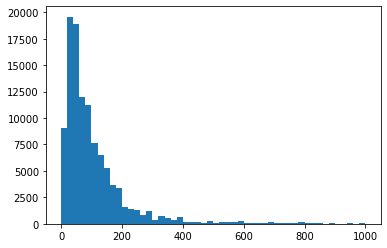

In [894]:
# let's see the distribution of item prices? why not.
plt.hist(data['items'].price, bins=50, range=(0, 1000));

*could this be a poisson? exponential?*

TODO: goodness of Fit on Monday

### Products

In [895]:
print(data['products'].columns)

Index(['product_id', 'product_category_name', 'product_photos_qty'], dtype='object')


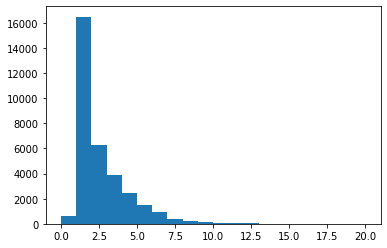

In [896]:
# histogram of number of photos in a product listing
plt.hist(data['products'].product_photos_qty, bins= 20);

In [897]:
# let's look at product categories
product_categories = data['products'].groupby('product_category_name').agg({'product_id':'count'}).sort_values(by='product_id', ascending=False)

([], <a list of 0 Text xticklabel objects>)

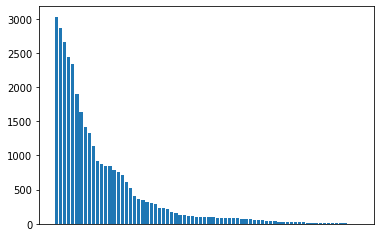

In [898]:
plt.bar(product_categories.index, [x[0] for x in product_categories.values])
plt.xticks([])

TODO: profile of customer and of seller (estimation of population)